In [166]:
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import List
import os 
from IPython.display import Image, display

os.environ["GOOGLE_API_KEY"]  = os.getenv("GOOGLE_API_KEY")
os.environ["OPENAI_API_KEY"]  = os.getenv("OPENAI_API_KEY")

In [167]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model

gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm = init_chat_model("openai:gpt-4.1", temperature=0.0)


In [168]:
from pydantic import BaseModel, Field
from typing import Literal

class PlanSchema(BaseModel):
    """A structured plan describing an individual task."""
    title: str = Field(..., description="A string describing the task")
    completed: Literal[True, False] = Field(..., description="Whether the task is completed")
    node: Literal["task_agent"] = Field(..., description="The node responsible for the task")

class State(MessagesState):
    plans: List[PlanSchema] = Field(default_factory=list)
    query:str
    

In [169]:
from langchain.tools import tool


class PlanList(BaseModel):
    plans: List[PlanSchema]

@tool
def plan_generator(query:str):
    """generate the plan based on the user query"""

    llm_with_structured_output = llm.with_structured_output(PlanList)
    prompt = """You are a top-notch planner assistant. Your job is to take any natural language task request and break it down into a well-structured plan.
    """

    result = llm_with_structured_output.invoke([
        {"role":"system","content":prompt },
        {"role":"user", "content":query }
    ])

    print(result,"result")

    return {"plans": result.plans or []}


In [170]:

tools = [plan_generator]

tools_by_name = {tool.name:tool for tool  in tools}
llm_with_tools = llm.bind_tools(tools)


def supervisor_node(state:State):
    """supervise all the plans"""

    supervisor_prompt = """
        You are a high-level executive task supervisor. Your job is to:
        - Review the user's query and any previous messages
        - Analyze what high-level tasks need to be accomplished
        - Generate one or more structured plans to accomplish the task
        - Use tools as needed (e.g., plan_generator) to generate those plans

        Only generate plans that are necessary, clear, and well-scoped.

        """
    
    return {
        "messages":[
            llm_with_tools.invoke([
                {"role":"system", "content":supervisor_prompt},
                {"role":"user", "content":state["query"]}
            ]
            + state["messages"]
            )
        ]
    }


    

In [171]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

In [172]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if it's a Done tool call
    if len(last_message.tool_calls) > 0:
        return "tool_handler"
    else:
        return END

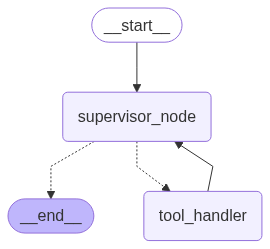

In [173]:


overall_flow = StateGraph(State)

# Add nodes
overall_flow.add_node("supervisor_node", supervisor_node)
overall_flow.add_node("tool_handler", tool_handler)

# Add edges
overall_flow.add_edge(START, "supervisor_node")
overall_flow.add_conditional_edges(
    "supervisor_node",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_flow.add_edge("tool_handler", "supervisor_node")

# Compile the agent
agent = overall_flow.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [174]:
response = agent.invoke({"query":"create a task , update a task and delete a task"})

for m in response["messages"]:
    m.pretty_print()

plans=[PlanSchema(title='Define the details and objectives of the new task', completed=False, node='task_agent')] result
plans=[PlanSchema(title='Identify the task to be updated', completed=False, node='task_agent'), PlanSchema(title='Gather the new information or changes for the task', completed=False, node='task_agent'), PlanSchema(title='Edit the task details with the updated information', completed=False, node='task_agent'), PlanSchema(title='Save and confirm the changes to the task', completed=False, node='task_agent')] result
plans=[PlanSchema(title='Identify the task to be deleted', completed=False, node='task_agent'), PlanSchema(title='Confirm deletion with the user (if necessary)', completed=False, node='task_agent'), PlanSchema(title='Remove the specified task from the task list or database', completed=False, node='task_agent'), PlanSchema(title='Update the task list to reflect the deletion', completed=False, node='task_agent')] result
================================== Ai Me